## Analysis

1. Temperature generally drop with laptitude increase
2. Observed trend 2
3. Observed trend 3


TODO: Run 500, output chart, match PDF

In [12]:
import os
import requests
import random
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from citipy import citipy
import geocoder
from config import WOM_API_KEY

class WeatherPy(object):
    
    _number_of_cities = None
    _cities_set = set()
    _cities_df = pd.DataFrame()
    _log_file = None
    _csv_file = None
    _png_file = None
    _actual_png_file = None

    _base_url = 'http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=' + WOM_API_KEY + '&q='
    _today = date.today().strftime('%m/%d/%y')
    
    @property
    def cities(self):
        return self._cities_df
    @property
    def number_of_cities(self):
        return self._number_of_cities
      
    def __init__(self, 
                 number_of_cities=None,
                 log_file=None,
                 csv_file=None,
                 png_file=None,
                 actual_png_file=None):
        self._number_of_cities = number_of_cities or 4 # Default to 4 for testing
        self._png_file = png_file
        self._actual_png_file = actual_png_file
        self.csv_file = csv_file
        if log_file:
            self._log_file = open(log_file, 'w')
        sns.set()
        sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
        
    def __del__(self):
        if self._log_file:
            self._log_file.close()

    def _pick_a_city(self, i):
        while True:
            lat, lon = (random.uniform(-90, 90), random.uniform(-180, 180))
            city = citipy.nearest_city(lat, lon)
            city_name = city.city_name
            country_code = city.country_code
            city_full = city_name + ',' + city.country_code

            self.log('Processing City # {} | {}'.format(i, city_full))

            # Check if city is already picked
            if city_full in self._cities_set:
                continue
            
            # Get actual location of the city.
            g = geocoder.google(city_full)
            if g:
                (actual_lat, actual_lon) = g.latlng
            else:
                self.log('Unable to get actual location of the city {}. Skip.'.format(city_full))
                continue
                
            # Check weather
            url = self._base_url + city_full
            self.log(url)
            response = requests.get(url)
            if response.status_code != 200:
                self.log('Weather not found for ' + city_full + '. Try another city.')
                continue

            w = response.json()   
            self._cities_df = self._cities_df.append(
                pd.DataFrame([{
                        'City Name': city_name,
                        'Country Code': country_code,
                        'Latitude': lat,
                        'Longitude': lon,
                        'Actual Latitude': actual_lat,
                        'Actual Longitude': actual_lon,
                        'Humidity': w['main']['humidity'],
                        'Temperature': w['main']['temp'],
                        'Wind Speed': w['wind']['speed'],
                        'Cloudiness': w['clouds']['all'],
                    }]
                )
            )

            self._cities_set.add(city_full)
            break
        
    def pick_all_cities(self):
        for i in range(self.number_of_cities):
            self._pick_a_city(i)
        
    def write_data_to_csv(self, csv_file=None):
        csv_file = csv_file or self._csv_file
        self.cities.to_csv(csv_file)
        
    def plot_lat_lon(self, use_actual=False):
        fig, ax = plt.subplots()
        if use_actual:
            self.cities.plot.scatter('Latitude', 'Longitude', ax=ax)
        else:
            self.cities.plot.scatter('Actual Latitude', 'Actual Longitude', ax=ax)
            
        plt.xlim(-90, 90); plt.ylim(-180, 180)
        plt.show()
        
    def plot_weather(self, use_actual=False):
        fig = plt.figure(figsize=(15,10))
        fig.suptitle("Correlation of City Latitude vs. Weather Metrics")

        x = 'Actual Latitude' if use_actual else 'Latitude'
        for i, metric in [(1, 'Temperature'),
                          (2, 'Humidity'),
                          (3, 'Cloudiness'),
                          (4, 'Wind Speed')]:
            self.cities.plot.scatter(x=x, y=metric, 
                                   title='City Latitude vs. {} ({})'.format(metric, self._today),
                                   ax=plt.subplot(2, 2, i)
                                   xlim=(-90, 90), ylim=(-180, 180))                          

        if use_actual and self._actual_png_file:
            print('save actual png')
            fig.savefig(self._actual_png_file)
        if not use_actual and self._png_file:
            fig.savefig(self._png_file)
        plt.show()

    def log(self, msg):
        if self._log_file:
            self._log_file.write(msg + '\n')
            self._log_file.flush() # Easier to see progress in tail -f
        else:
            print(msg)

SyntaxError: invalid syntax (<ipython-input-12-74a751bc687d>, line 131)

In [6]:
weather_py = WeatherPy(
    number_of_cities=100,
    log_file='weather_py.log',
    csv_file='weather_py.csv',
    png_file='weather_py.png',
    actual_png_file='weather_actual.png',
)
weather_py.pick_all_cities()

In [7]:
weather_py.cities.head()

,Actual Latitude,Actual Longitude,City Name,Cloudiness,Country Code,Humidity,Latitude,Longitude,Temperature,Wind Speed
0,35.152283,140.320932,katsuura,0,jp,85,24.688395,151.561506,39.71,6.85
0,-34.409200,19.250444,hermanus,20,za,47,-73.442295,-0.244345,75.08,4.83
0,-23.621285,-70.381877,castro,64,cl,87,-46.223473,-80.652007,57.80,4.90
0,64.432720,-173.238567,provideniya,48,ru,100,59.273265,-170.761286,-0.44,14.56
0,-20.405950,57.703422,mahebourg,40,mu,74,-39.056578,75.616516,82.40,12.75


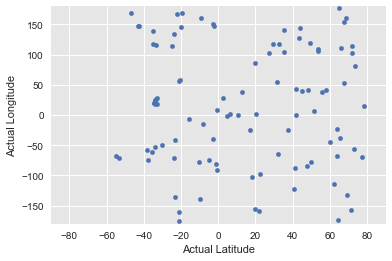

In [8]:
weather_py.plot_lat_lon()

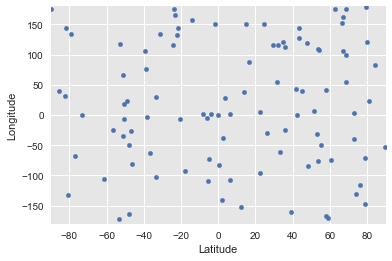

In [9]:
weather_py.plot_lat_lon(use_actual=True)

use_actual: False
actual_png_file: weather_actual.png


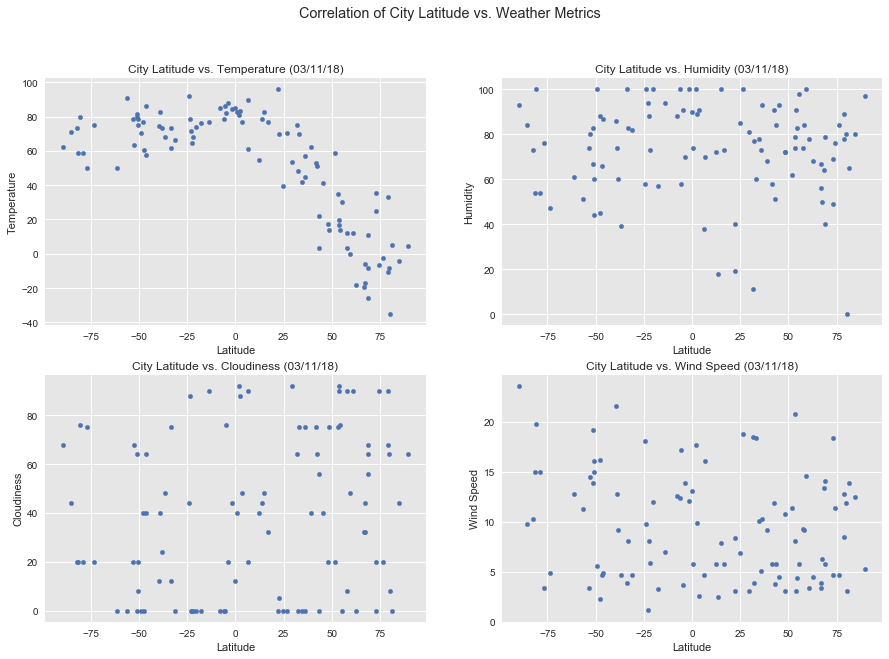

In [10]:
weather_py.plot_weather()

use_actual: True
actual_png_file: weather_actual.png
save actual png


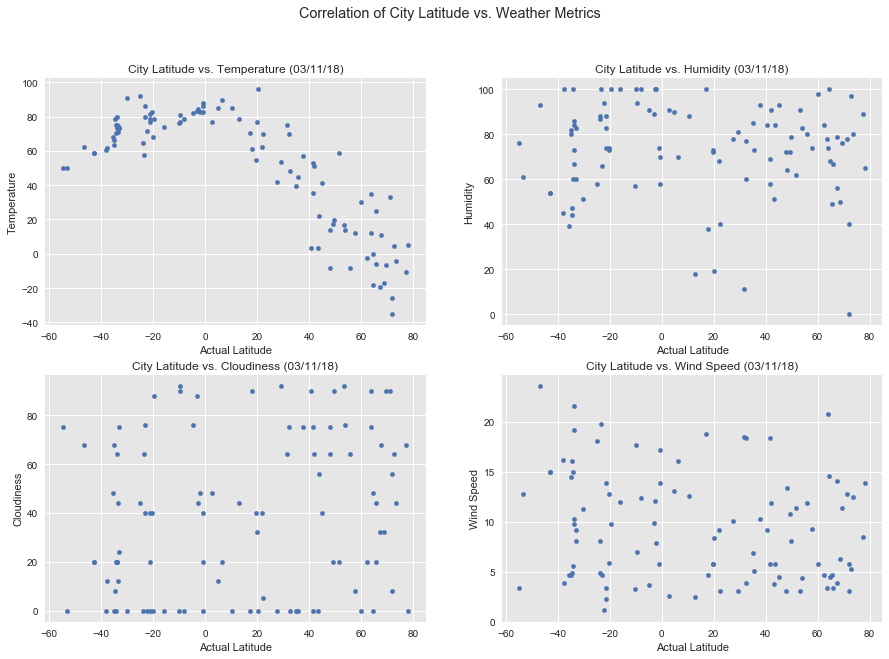

In [11]:
weather_py.plot_weather(use_actual=True)

### Destruct object to clean up

In [179]:
del weather_py

# Below Is My original Solution w/o Using Python Class

In [ ]:
import os
import requests
import random
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from citipy import citipy
import geocoder
from config import WOM_API_KEY

N = 500

sns.set()
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

BASE_URL = 'http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=' + WOM_API_KEY + '&q='
TODAY = date.today().strftime('%m/%d/%y')

In [143]:
# Use set to ensure uniuqeness of city
# Add country code to get better precision of weather information

cities_set = set()
while True:
    lat, lon = (random.uniform(-90, 90), random.uniform(-180, 180))
    city = citipy.nearest_city(lat, lon)
    cities_set.add((city.city_name, city.country_code, lat, lon))
    if len(cities_set) >= 2 * N: break     

df_cities = pd.DataFrame(
    list(cities_set),
    columns=['City Name', 'Country Code', 'Latitude', 'Longitude'])

In [144]:
df_cities.to_csv('cities.csv')

## Check Randomness

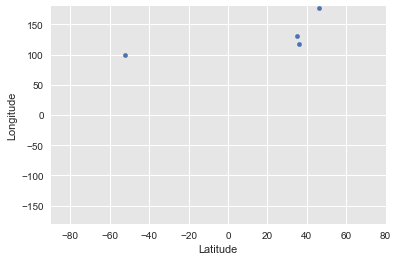

In [145]:
df_cities.plot.scatter('Latitude', 'Longitude')
plt.xlim(-90, 80); plt.ylim(-180, 180)
plt.show()

From the scatter plot the distribution is pretty random.

In [146]:
df_cities

,City Name,Country Code,Latitude,Longitude
0,yishui,cn,35.942861,118.453633
1,nagato,jp,34.943311,131.194234
2,nikolskoye,ru,46.455729,177.956045
3,busselton,au,-52.265402,98.972754


## Scrap Weather Info
With 2 * N cities, query cities and if weather info not found, skip it, until reach N cities.

In [147]:
found = 0
for i in df_cities.index:
    city = '{},{}'.format(*df_cities.loc[i, ['City Name', 'Country Code']])
    url = BASE_URL + city
    print('Processing Record {} | {}\n{}'.format(i, city, url))
    
    response = requests.get(url)
    if response.status_code != 200:
        print('Weather not found for ' + city)
        continue

    w = response.json()   
    df_cities.loc[i, 'Humidity'] = w['main']['humidity']
    df_cities.loc[i, 'Temperature'] = w['main']['temp']
    df_cities.loc[i, 'Wind Speed'] = w['wind']['speed']
    df_cities.loc[i, 'Cloudiness'] = w['clouds']['all']
    
    found += 1
    if found == N:
        break
        
df_cities = df_cities[df_cities['Temperature'].notnull()]

Processing Record 0 | yishui,cn
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=005c82cb8c035cbefecab652ccba00f1&q=yishui,cn
Processing Record 1 | nagato,jp
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=005c82cb8c035cbefecab652ccba00f1&q=nagato,jp


## Recheck Randomness

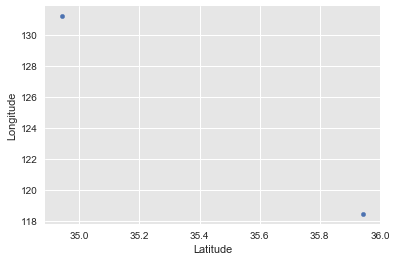

In [148]:
df_cities.plot.scatter('Latitude', 'Longitude')
plt.show()

### Plot Laptitude Vs Weather Metrics

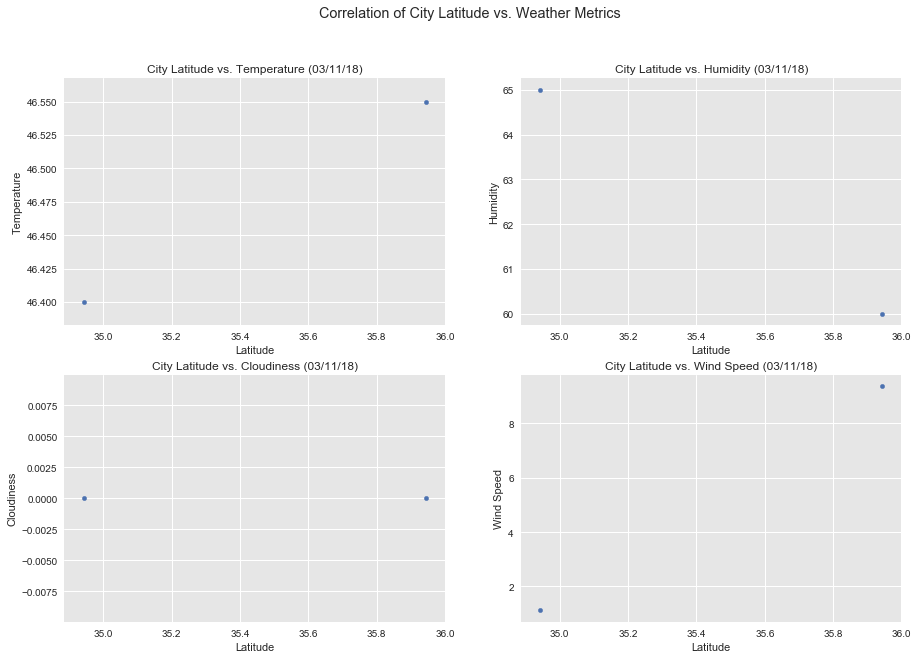

In [150]:
fig = plt.figure(figsize=(15,10))
fig.suptitle("Correlation of City Latitude vs. Weather Metrics")

for i, metric in [(1, 'Temperature'),
                  (2, 'Humidity'),
                  (3, 'Cloudiness'),
                  (4, 'Wind Speed')]:
    df_cities.plot.scatter(x='Latitude', y=metric, 
                           title='City Latitude vs. {} ({})'.format(metric, TODAY),
                           ax=plt.subplot(2, 2, i))                          

fig.savefig('weather_py.png')
plt.show()